<a href="https://colab.research.google.com/github/darkwings/ai-notebooks/blob/main/Routing_with_some_intelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Intelligent" routing

This notebook shows how to mimic a rule engine with a LLM, using Commands.

Use case is simple. A user ask for an advice about what to do.
- If the question is related to music and is about learning a song, the flow will reason and propose a decent solution, one of
  - practice (if the song is easy but there is short time)
  - study (if the song is difficult)
  - sleep (if the model detects that the user is tired, it can suggest to sleep)
- If the model cannot decide what to do, it demands to the throwing of a coin.

Despite the name of this notebook, the example is quite trivial, but it shows how the model can drive a flow.

If you imagine a more complex use case, and more complex reasoning involved, it's quite easy to understand how this feature can be really useful.

Evaluation of responses is out of the scope of this notebook. In the real world the workflow should be thoroughly tested to check if the decisions taken have sense.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


Now import all the stuff

In [11]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import Literal
from langgraph.types import Command
from pydantic import BaseModel
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
import random

Let's define state and all necessary functions

In [45]:
# Graph state
class RuleState(TypedDict):
  question: str
  reasoning: str
  short_advice: str
  action: Literal["practice", "study", "sleep", "coin"]

# LLM Answer
class Answer(BaseModel):
  reasoning: str
  action: Literal["practice", "study", "sleep", "coin"]

# Model
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)

system_prompt="""
You're in charge to decide the next action a user should take.

Your role is to give an advice to a guitar player, suggesting the proper
action given a question. You have to strictly follow these rules:

- If you understand from the question that the player needs to practice, please suggest him to "practice".
- If you understand from the question that the song is very difficult, please suggest him to "study".
- If you understand from the question that the player needs to rest, please suggest him to "sleep".
- If you don't know what to do, throw a "coin".

Please explain the reasoning behind your decision.
"""

def decision_node(state: RuleState) -> Command[Literal["practice", "study", "sleep", "coin"]]:
  messages = [HumanMessage(content=f"The question is {state['question']}")]

  answer = llm.with_structured_output(Answer).invoke([SystemMessage(content=system_prompt)]+messages)

  return Command(
    update={"action": answer.action, "reasoning": answer.reasoning},
    goto=answer.action,
  )

def practice(state: RuleState):
  # Do stuff
  return {"short_advice": "PRACTICE!"}

def study(state: RuleState):
  # Do stuff
  return {"short_advice": "STUDY!"}

def sleep(state: RuleState):
  # Do stuff
  return {"short_advice": "TAKE A NAP!"}

def coin(state: RuleState) -> Command[Literal["practice", "study"]]:
  coin = random.choice(["head", "tail"])
  if coin == "head":
    goto = "practice"
  else:
    goto = "study"
  print(f"I threw a coin, the result is {coin} so you have to {goto}!")
  return Command(
    goto=goto
  )

Now we can assemble the graph. We are using commands, so there is no need to define edges.

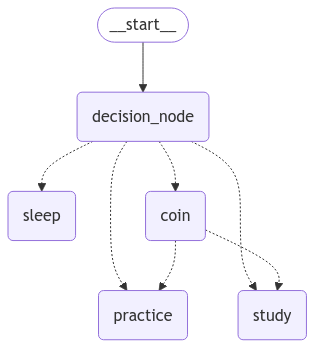

In [46]:
builder = StateGraph(RuleState)
builder.add_edge(START, "decision_node")
builder.add_node(decision_node)
builder.add_node(practice)
builder.add_node(study)
builder.add_node(sleep)
builder.add_node(coin)


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Now we can test the graph

In [47]:
ans = graph.invoke({"question": "I have to learn a new song by tomorrow, it is not difficult but there is short time. What do you suggest?"})
print(f"{ans['short_advice']}")
print(f"Why? {ans['reasoning']}")

PRACTICE!
Why? The player mentions that the song is not difficult, but they have a short time to learn it. This suggests that they need to focus on practicing to ensure they can play the song well by tomorrow.


Now let's try with an out of scope question. We can see that the model will redirect flow to the "coin" node

In [48]:
ans = graph.invoke({"question": "There is high probability of rain tomorrow"})
print(f"{ans['short_advice']}")
print(f"Why? {ans['reasoning']}")

I threw a coin, the result is tail so you have to study!
STUDY!
Why? The question about the probability of rain tomorrow does not relate to guitar playing or any of the specific actions like practicing, studying, or sleeping. It seems unrelated to the context of guitar playing, so it's unclear what action should be taken based on this information.


And what if user is tired?

In [49]:
ans = graph.invoke({"question": "Yaaaawwn!"})
print(f"{ans['short_advice']}")
print(f"Why? {ans['reasoning']}")

TAKE A NAP!
Why? The user is yawning, which is a common sign of tiredness or fatigue. This suggests that the player might need to rest.
